This is a prototype of the desired workflow of solving a QBAF that contains support links and nodes of topics and product.

In [1]:
import pandas as pd
import numpy as np
from reasoner.models import CountinuousDFQuADModel
from reasoner.solver import Solver
from reasoner.utilities import Collector, Adaptor

In [2]:
# load data
fpath = "./data/chunks.csv"
chunks = pd.read_csv(fpath)
chunks

,argument_id,chunk,topic,rank,polarity_score
0,0,I always get a half size up in my tennis shoes .,4,0.500000,-0.166667
1,0,For some reason these feel to big in the heel ...,15,0.500000,-0.050000
2,1,walked 3 hours with no problem,8,0.248569,0.000000
3,1,Put them on and !,3,0.254298,0.000000
4,1,Love them !,2,0.246981,0.625000
...,...,...,...,...,...
1193,369,I can wear the shoe all day long and,3,0.125414,-0.050000
1194,369,they are easy to clean compared to other shoes...,0,0.126618,0.225000
1195,369,They are light colored so any dirt will be see...,18,0.126863,0.342857
1196,369,Would definitely buy another pair in a differe...,16,0.124921,0.000000


In [3]:
# remove all chunks of an review
def remove_review_by_id(review_id, chunks):
    result = chunks[chunks["argument_id"] != review_id].reset_index(drop=True)
    return result

remove_review_by_id(0, chunks)

,argument_id,chunk,topic,rank,polarity_score
0,1,walked 3 hours with no problem,8,0.248569,0.000000
1,1,Put them on and !,3,0.254298,0.000000
2,1,Love them !,2,0.246981,0.625000
3,1,So light feeling,9,0.250153,0.400000
4,2,excelente,-1,1.000000,0.000000
...,...,...,...,...,...
1191,369,I can wear the shoe all day long and,3,0.125414,-0.050000
1192,369,they are easy to clean compared to other shoes...,0,0.126618,0.225000
1193,369,They are light colored so any dirt will be see...,18,0.126863,0.342857
1194,369,Would definitely buy another pair in a differe...,16,0.124921,0.000000


In [4]:
# create node and link dataframes
def get_nodes(chunks):
    topics = chunks["topic"].unique().tolist()
    topics.remove(-1)
    topics.sort()
    topics = [f"Topic {t}" for t in topics]
    topics.append("Product")
    
    chunk_text = chunks["chunk"]
    chunk_text = pd.concat([chunk_text, pd.Series(topics)], ignore_index=True)
    
    result = pd.DataFrame({"chunk": chunk_text}) 
    result["weight"] = 0.5
    return result

def get_supports(chunks):
    topic_index_start = max(chunks.index) + 1
    topics = chunks["topic"].unique().tolist()
    topics.remove(-1)
    topics.sort()
    product_index = topic_index_start + len(topics)
   
    # add supports between chunks and topics
    supports = chunks[chunks["polarity_score"] >= 0]
    supports = supports[supports["topic"] != -1]
    supports["chunk_id"] = supports.index
    supports = supports[["chunk_id", "topic"]]
    supports = supports.reset_index(drop=True)
    supports["topic"] += topic_index_start
    supports = supports.rename(columns={
        "chunk_id": "source", 
        "topic": "target"
    })
    
    # add support between topics and product
    new_rows = pd.DataFrame({"source": list(range(topic_index_start, topic_index_start + len(topics)))})
    new_rows["target"] = product_index
    supports = pd.concat([supports, new_rows], ignore_index=True) 
    supports = supports.astype(int)
    return supports

def get_attacks(chunks):
    topic_index_start = max(chunks.index) + 1
   
    # add supports between chunks and topics
    attacks = chunks[chunks["polarity_score"] < 0]
    attacks = attacks[attacks["topic"] != -1]
    attacks["chunk_id"] = attacks.index
    attacks = attacks[["chunk_id", "topic"]]
    attacks = attacks.reset_index(drop=True)
    attacks["topic"] += topic_index_start
    attacks = attacks.rename(columns={
        "chunk_id": "source", 
        "topic": "target"
    })
    attacks = attacks.astype(int)
    return attacks

In [5]:
# build adaptor of input data
nodes = get_nodes(chunks)
supports = get_supports(chunks)
attacks = get_attacks(chunks)
adaptor = Adaptor(arguments=nodes, weight_col="weight", attacks=attacks, supports=supports)

In [6]:
nodes

,chunk,weight
0,I always get a half size up in my tennis shoes .,0.5
1,For some reason these feel to big in the heel ...,0.5
2,walked 3 hours with no problem,0.5
3,Put them on and !,0.5
4,Love them !,0.5
...,...,...
1219,Topic 21,0.5
1220,Topic 22,0.5
1221,Topic 23,0.5
1222,Topic 24,0.5


In [7]:
supports

,source,target
0,2,1206
1,3,1201
2,4,1200
3,5,1207
4,7,1219
...,...,...
1060,1218,1223
1061,1219,1223
1062,1220,1223
1063,1221,1223


In [8]:
attacks

,source,target
0,0,1202
1,1,1213
2,8,1213
3,9,1213
4,42,1215
...,...,...
129,1158,1217
130,1173,1214
131,1186,1201
132,1191,1206


In [9]:
# build solver
n_topics = chunks["topic"].unique().size
model = CountinuousDFQuADModel(data_adaptor=adaptor)
solver = Solver(model=model, step_size=0.1, max_steps=10e4, epsilon=10e-4)
final_step, collector = solver.solve(solver="RK4", collect_data=True)
final_step, model.strength_vector[-n_topics:]

(38,
 array([0.50096052, 0.56147355, 0.6229471 , 0.50012007, 0.50000001,
        0.7458942 , 0.7458942 , 0.53073677, 0.50024013, 0.6229471 ,
        0.9917884 , 0.56147355, 0.7458942 , 0.51536836, 0.7458942 ,
        0.50000001, 0.53073677, 0.51536839, 0.7458942 , 0.53072177,
        0.6229471 , 0.50768418, 0.74589408, 0.62294616, 0.56141352,
        0.9917884 ]))

By using `fix_last` param of the `Solver.solve` function, it will ignore the compute of part of the strength vector from the beginning until `-fix_last`. This is based on the assumption that we know that part of strength vector will not be updated due to 0 parent vector. And this will save a significant amount of computing time.

In [10]:
model_opt = CountinuousDFQuADModel(data_adaptor=adaptor)
solver_opt = Solver(model=model_opt, step_size=0.1, max_steps=10e4, epsilon=10e-4)
final_step, collector = solver_opt.solve(solver="RK4", collect_data=True, update_last=n_topics)
final_step, model_opt.strength_vector[-n_topics:]

(38,
 array([0.50096052, 0.56147355, 0.6229471 , 0.50012007, 0.50000001,
        0.7458942 , 0.7458942 , 0.53073677, 0.50024013, 0.6229471 ,
        0.9917884 , 0.56147355, 0.7458942 , 0.51536836, 0.7458942 ,
        0.50000001, 0.53073677, 0.51536839, 0.7458942 , 0.53072177,
        0.6229471 , 0.50768418, 0.74589408, 0.62294616, 0.56141352,
        0.9917884 ]))

In [11]:
# As shown, the result after optimzing computation is the same as that without optimization, while the time spent is much shorter.
np.array_equal(model.strength_vector, model_opt.strength_vector)

True

In [12]:
result = []
for i in chunks["argument_id"].unique():
    part_chunks = remove_review_by_id(i, chunks)
    nodes = get_nodes(part_chunks)
    supports = get_supports(part_chunks)
    attacks = get_attacks(part_chunks)
    n_topics = part_chunks["topic"].unique().size
    adaptor = Adaptor(arguments=nodes, weight_col="weight", attacks=attacks, supports=supports)
    model = CountinuousDFQuADModel(data_adaptor=adaptor)
    solver = Solver(model=model, step_size=0.5, max_steps=10e4, epsilon=10e-4)
    final_step, _ = solver.solve(solver="RK4", update_last=n_topics)
    result.append(model.strength_vector[-1])
                                 

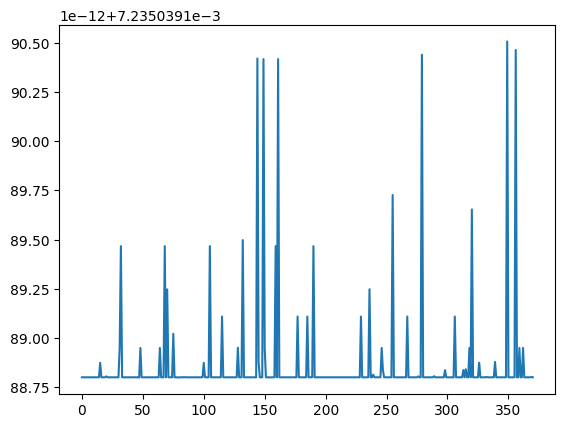

In [15]:
import matplotlib.pyplot as plt

gaps = np.array(result) - model_opt.strength_vector[-1]
plt.plot(gaps)
plt.show()